"""
Simple ConvNet trained on Chest X-Ray using custom GaborConv2D layer.
"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks ludviadhira

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Activation, GlobalMaxPool2D
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, load_model
from sklearn.preprocessing import LabelEncoder

# u/ Evaluasi Model
import itertools
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.metrics import  precision_recall_curve, auc, roc_curve, roc_auc_score

from glob import glob
#from gabor_conv import GaborConv2D, _gabor_filter
#import gabor
#from gabor_init import gabor_init

# Path Directory 

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset Efusi Pleura/'

train_dir = os.path.join(base_dir, 'train/')
validation_dir = os.path.join(base_dir, 'test/')
print('Number of train images = ',str(len(glob(train_dir+'*/*'))))
print('Number of validation images = ',str(len(glob(validation_dir+'*/*'))))

# Directory with our training healthy/sick pictures
train_healthy_dir = os.path.join(train_dir, 'nofinding')
train_sick_dir = os.path.join(train_dir, 'effusion')
print('Number of train healthy images = ',str(len(glob(train_healthy_dir+'*/*'))))
print('Number of train sick images = ',str(len(glob(train_sick_dir+'*/*'))))

# Directory with our validation healthy/sick pictures
validation_healthy_dir = os.path.join(validation_dir, 'nofinding')
validation_sick_dir = os.path.join(validation_dir, 'effusion')
print('Number of validation healthy images = ',str(len(glob(validation_healthy_dir+'*/*'))))
print('Number of validation sick images = ',str(len(glob(validation_sick_dir+'*/*'))))

train_healthy_fnames = os.listdir( train_healthy_dir )
train_sick_fnames = os.listdir( train_sick_dir )

Number of train images =  320
Number of validation images =  80
Number of train healthy images =  160
Number of train sick images =  160
Number of validation healthy images =  40
Number of validation sick images =  40


# Path Load Files

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset TT'

train_dir = os.path.join(base_dir, 'training/')
test_dir = os.path.join(base_dir, 'test/')
print('Number of train images = ',str(len(glob(train_dir+'*/*'))))
print('Number of test images = ',str(len(glob(test_dir+'*/*'))))

# Directory with our training healthy/sick pictures
train_healthy = os.listdir(train_dir + 'nofinding')
train_sick = os.listdir(train_dir + 'effusion')
print('Number of train healthy images = ', len(train_healthy))
print('Number of train sick images = ', len(train_sick))

# Directory with our validation healthy/sick pictures
test_healthy = os.listdir(test_dir+ 'nofinding')
test_sick = os.listdir(test_dir+ 'effusion')
print('Number of test healthy images = ',len(test_healthy))
print('Number of test sick images = ',len(test_sick))

#train_healthy_fnames = os.listdir( train_healthy_dir )
#train_sick_fnames = os.listdir( train_sick_dir )

Number of train images =  200
Number of test images =  200
Number of train healthy images =  100
Number of train sick images =  100
Number of test healthy images =  100
Number of test sick images =  100


# Input shape 

In [ ]:
img_height, img_width  = 128, 128


if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

# **PREPROCESSING**

# [2.1] Gathering Data , Resizing image
Melakukan gathering data dengan membentuk data train, data test dan data validation yang berisi gambar dan label serta melakukan resizing image menjadi ukuran 128x128 untuk menyeragamkan ukuran gambar.

In [ ]:
# Mendeklarasikan ukuran gambar
img_size = (128,128)
# Mendeklarasikan kategori gambar
categories = ['effusion', 'nofinding']

training_data = []
testing_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(train_dir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(330,330)) 
                crop = new_array[150:278,25:153]
                training_data.append([crop,class_num])
            except Exception as e:
                pass

def create_testing_data():
    for category in categories:
        path = os.path.join(test_dir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(330,330)) 
                crop = new_array[150:278,25:153]
                testing_data.append([crop,class_num])
            except Exception as e:
                pass


create_training_data()
print("Berhasil Create Training Data")
create_testing_data()
print("Berhasil Create Testing Data")

Berhasil Create Training Data
Berhasil Create Testing Data


# [2.2] Normalisasi dan Labeling Data
Melakukan Normalisasi data dimana setiap pixel yang memiliki range 0-255 akan dinormalisasikan menjadi range 0-1 dan labeling data

In [ ]:
# Melakukan pengambilan features/gambar dan label dari masing" kelas

X_train = []
Y_train = []
for features,label in training_data:
    X_train.append(features)
    Y_train.append(label)
X_train = np.array(X_train).reshape(-1,128,128)
X_train = X_train.astype('float32')/255.0  # normalize train data
X_train = X_train.reshape(-1,128,128,3)    # reshape dataset to feed it into model properly
Y_train = np.array(Y_train)
print("Train Data = ", X_train.shape)
print("Train Label = ", Y_train.shape)

X_test = []
Y_test = []
for features,label in testing_data:
    X_test.append(features)
    Y_test.append(label)
X_test = np.array(X_test).reshape(-1,128,128)
X_test = X_test.astype('float32')/255.0  # normalize test data
X_test = X_test.reshape(-1,128,128,3)    # reshape dataset to feed it into model properly
Y_test = np.array(Y_test)
print("Test Data = ", X_test.shape)
print("Test Label = ", Y_test.shape)

Train Data =  (200, 128, 128, 3)
Train Label =  (200,)
Test Data =  (200, 128, 128, 3)
Test Label =  (200,)


Labeling Data menggunakan label encoder untuk Y_train/val/test

In [ ]:
lb = LabelEncoder()

Y_train = lb.fit_transform(Y_train)
Y_test = lb.fit_transform(Y_test)

# **AUGMENTASI DATA**
Implementasi Augmentasi Data menggunakan library Keras bernama ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False,  
        #vertical_flip=False,
        fill_mode='nearest')  

# **FILTER GABOR**

Membentuk fungsi grayscale untuk mengubah gambar menjadi warna grayscale

In [ ]:
def grayscale(data, dtype='float32'):
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    return rst

Membentuk fungsi add_dimension untuk mengubah urutan matrix

In [ ]:
def add_dimension(data):
    data = np.array([data])
    print(data.shape)
    data = np.einsum('hijk->ijkh', data)   #re arange the dimension
    return data

Implementasi filter gabor dengan membuat fungsi bernama custom gabor yang menerapkan Garborkernel dari library Open CV

In [ ]:
def custom_gabor(shape, dtype=None):
    pi = np.pi
    orientation_spread = np.array([0, pi/6, pi/3, pi/2, pi*2/3, pi*5/6, pi, pi*7/6])
    scales = np.linspace(2, 4, 2)
    real_kernels = []
    img_kernels = []
    for orientation in orientation_spread:
        for scale in scales:
            real_kernel = cv2.getGaborKernel((3, 3), 1, orientation, scale, 1, 0)
            imaginary_kernel = cv2.getGaborKernel((3, 3), 1, orientation, scale, 1, np.pi / 2)
            real_kernels.append(real_kernel)
            img_kernels.append(imaginary_kernel)
    stacked_list = np.vstack((real_kernels, img_kernels))
    stacked_list = np.array([stacked_list])
    stacked_list = np.einsum('hijk->jkhi', stacked_list)
    print(stacked_list.shape)

    stacked_list = K.variable(stacked_list)
    random = K.random_normal(shape, dtype=dtype)
    return stacked_list

Melakukan penerapan filter gabor pada data train test dan validation sehingga data akan berubah menjadi 1 channel warna

In [ ]:
X_train_gabor = add_dimension(grayscale(X_train))
X_test_gabor = add_dimension(grayscale(X_test))
Y_train_gabor = Y_train
Y_test_gabor = Y_test

(1, 200, 128, 128)
(1, 200, 128, 128)


# **PENGUJIAN MODEL**

# Rancangan Model

APL Dropout : 0.05, Dropout : 0.25, Dense : 128

In [ ]:
#input_shape=[128,128,1]

model = Sequential()

model.add(InputLayer(input_shape=[128,128,1]))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=custom_gabor, data_format='channels_last', strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.05))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.05))
'''
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=3, padding='same'))
model.add(Dropout(0.05))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=3, padding='same'))
model.add(Dropout(0.05))
'''
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.05))

#model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=3, padding='same'))
#model.add(Dropout(0.05))

#model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=3, padding='same'))
#model.add(Dropout(0.05))

model.add(GlobalMaxPool2D())
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#model.summary()

(3, 3, 1, 32)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer=custom_gabor, input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])
#model.summary()

(3, 3, 1, 32)


In [ ]:
#Plot Diagram CNN
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

Skenario model menggunakan Optimizer Adam dengan learning rate 0.00146 dan loss binary crossentropy

In [ ]:
#from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=Adamax(learning_rate=0.00146, decay=1e-5),
              #optimizer=RMSprop(learning_rate=0.0001), 
              ##optimizer=keras.optimizers.SGD(lr=0.01),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Implementasi Callback berupa Learning rate Scheduler

In [ ]:
#filepath="/content/drive/MyDrive/[Trial] Simponia/Model_Skenario3.h5"

checkpoint = callbacks.ModelCheckpoint(
                                       filepath,
                                       monitor='val_accuracy',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='auto',
                                       )

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
# Define the callbacks

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Training Model

In [ ]:
import time
session_num = 0
batch_size=32

start = time.time()
datagen.fit(X_train_gabor)
history = model.fit(datagen.flow(X_train_gabor,Y_train_gabor, batch_size=batch_size),
                              epochs = 200, validation_data = (X_test_gabor,Y_test_gabor),
                              steps_per_epoch = X_train_gabor.shape[0] // batch_size,
                              class_weight={0:6.1, 1:2.1}, 
                              verbose=1),
                              #callbacks=[early_stopping_cb])
                              #callbacks=[lr_schedule,checkpoint])
stop = time.time()

Epoch 1/200
6/6 [==============================] - 11s 2s/step - loss: 10.7846 - accuracy: 0.4881 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 2/200
6/6 [==============================] - 9s 2s/step - loss: 7.4182 - accuracy: 0.4702 - val_loss: 0.7100 - val_accuracy: 0.5000
Epoch 3/200
6/6 [==============================] - 9s 2s/step - loss: 4.6387 - accuracy: 0.5119 - val_loss: 0.7300 - val_accuracy: 0.5000
Epoch 4/200
6/6 [==============================] - 9s 2s/step - loss: 4.8013 - accuracy: 0.5238 - val_loss: 0.7335 - val_accuracy: 0.5000
Epoch 5/200
6/6 [==============================] - 9s 2s/step - loss: 4.9929 - accuracy: 0.5000 - val_loss: 0.7433 - val_accuracy: 0.5000
Epoch 6/200
6/6 [==============================] - 12s 2s/step - loss: 4.2139 - accuracy: 0.5179 - val_loss: 0.7416 - val_accuracy: 0.5000
Epoch 7/200
6/6 [==============================] - 9s 2s/step - loss: 4.6826 - accuracy: 0.4702 - val_loss: 0.7409 - val_accuracy: 0.5000
Epoch 8/200
6/6 [==============

Save Model

In [ ]:
from keras.models import load_model
model.save('model_1.h5')
model_1 = load_model('model_1.h5')

# Visualisasi Model

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'c')
ax1.set_title('Accuracy | Skenario 3')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'c')
ax2.set_title('Loss | Skenario 3')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

AttributeError: ignored

# Evaluasi Model

Evaluasi Data Train

In [ ]:
loss, acc = model.evaluate(X_train_gabor,Y_train_gabor,verbose = 1)
print("Training Loss {:.5f}".format(loss))
print("Training Accuracy {:.2f}%".format(acc*100))

7/7 [==============================] - 2s 269ms/step - loss: 0.4174 - accuracy: 0.8550
Training Loss 0.41743
Training Accuracy 85.50%


Evaluasi Data Test

In [ ]:
loss, acc = model.evaluate(X_test_gabor,Y_test_gabor,verbose = 1)
print("Test Loss {:.5f}".format(loss))
print("Test Accuracy {:.2f}%".format(acc*100))

7/7 [==============================] - 3s 490ms/step - loss: 0.6781 - accuracy: 0.6700
Test Loss 0.67815
Test Accuracy 67.00%


Classification Report

In [ ]:
print("Skenario Model")
pred = model.predict(X_test_gabor)
labels = (pred > 0.5).astype(np.int)

print(classification_report(Y_test_gabor, labels, target_names = categories))

Skenario Model
              precision    recall  f1-score   support

    effusion       0.76      0.88      0.81        40
   nofinding       0.85      0.72      0.78        40

    accuracy                           0.80        80
   macro avg       0.81      0.80      0.80        80
weighted avg       0.81      0.80      0.80        80



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


# **ROC Curve**

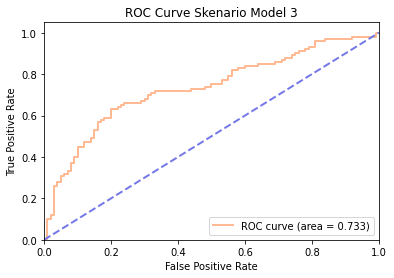

In [ ]:
import matplotlib.pyplot as plt

pred_val = model.predict(X_test_gabor)
fpr, tpr, _ = roc_curve(Y_test_gabor, pred_val)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='#ffba93',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#7579e7', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Skenario Model 3')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auc_score = roc_auc_score(Y_test_gabor, pred_val)
fpr, tpr, th = roc_curve(Y_test_gabor, pred_val)
print('AUC Score Skenario Model 3 = ', round(auc_score, 3))

AUC Score Skenario Model 3 =  0.597


# **PREDIKSI DATA**

In [ ]:
def predict_image(filename):
    img = load_img(filename, target_size=(128, 128))
    image = keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(1,128,128,3)
    model = load_model('model_1.h5')
    prediction = model.predict(image)
    plt.imshow(img)
    if(prediction[0] > 0.5):
        print("predicted: EFUSI")
    else:
        print("predicted: NORMAL")
   
predict_image('/content/drive/MyDrive/Colab Notebooks/Dataset TT/test/nofinding/00003945_011.png')

**BLANK**
---
---

In [ ]:
# Performing Image Augmentation to have more data samples
img_height, img_width  = 128, 128
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='binary')

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
#Display 10 random image
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:'nofinding', 1:'effusion'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(96, kernel_size=(5,5), padding='valid',
                     #kernel_initializer=_gabor_filter, 
                     kernel_initializer=gabor_init,
                     bias_initializer='zeros',
                     activation='relu', 
                     input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),  activation='relu', padding='valid', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="valid", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

In [ ]:
model = models.Sequential()
model.add(Conv2D(96, kernel_size=(5, 5), strides=(1, 1),
          kernel_initializer=gabor_init,
          activation='relu',
          input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.summary()

In [ ]:
#Defining Callback list
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

#Assigning Class Weights
from sklearn.utils.class_weight import compute_class_weight
train_classes = train_generator.classes
#weights = compute_class_weight('balanced', np.unique(train_classes), train_classes)
#cw = dict(zip( np.unique(train_generator.classes), weights))
#print(cw)

class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes )
class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

history = model.fit(train_generator,
                              epochs=25, 
                              validation_data=validation_generator, 
                              class_weight=class_weights, 
                              callbacks=callbacks_list)